In [1]:
!pip install ydf koolbox scikit-learn==1.5.2 && pip install --no-deps scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Imports and configs

In [2]:
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from scikeras.wrappers import KerasRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from koolbox import Trainer
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shutil
import optuna
import keras
import json
import glob
import ydf

ydf.verbose(2)
warnings.filterwarnings("ignore")

2025-05-12 19:14:21.530992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747077261.787298      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747077261.859875      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e5/train.csv"
    test_path = "/kaggle/input/playground-series-s5e5/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e5/sample_submission.csv"
    
    original_path = "/kaggle/input/calories-burnt-prediction/calories.csv"

    metric = root_mean_squared_error
    target = "Calories"
    n_folds = 5
    seed = 42

    cv = KFold(n_splits=n_folds, random_state=seed, shuffle=True)

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train = train.drop_duplicates(subset=train.columns, keep='first').reset_index(drop=True)
train = train.groupby(by=test.columns.tolist())['Calories'].min().reset_index()

train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

X = train.drop(CFG.target, axis=1)
y = np.log1p(train[CFG.target])
X_test = test

In [5]:
original = pd.read_csv(CFG.original_path, index_col="User_ID")
original["Gender"] = original["Gender"].map({"male": 0, "female": 1})
original = original.rename(columns={"Gender": "Sex"})

original = original.drop_duplicates(subset=original.columns, keep='first').reset_index(drop=True)
original = original.groupby(by=test.columns.tolist())['Calories'].min().reset_index()

X_original = original.drop(CFG.target, axis=1)
y_original = np.log1p(original[CFG.target])

In [6]:
mutual_info = mutual_info_regression(X, y, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Duration,1.638776
Body_Temp,1.117558
Heart_Rate,0.975924
Age,0.094534
Height,0.053616
Weight,0.053206
Sex,0.015762


In [7]:
mutual_info = mutual_info_regression(X_original, y_original, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_original.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Duration,1.506871
Body_Temp,0.979288
Heart_Rate,0.869781
Age,0.036461
Weight,0.022123
Sex,0.018845
Height,0.008272


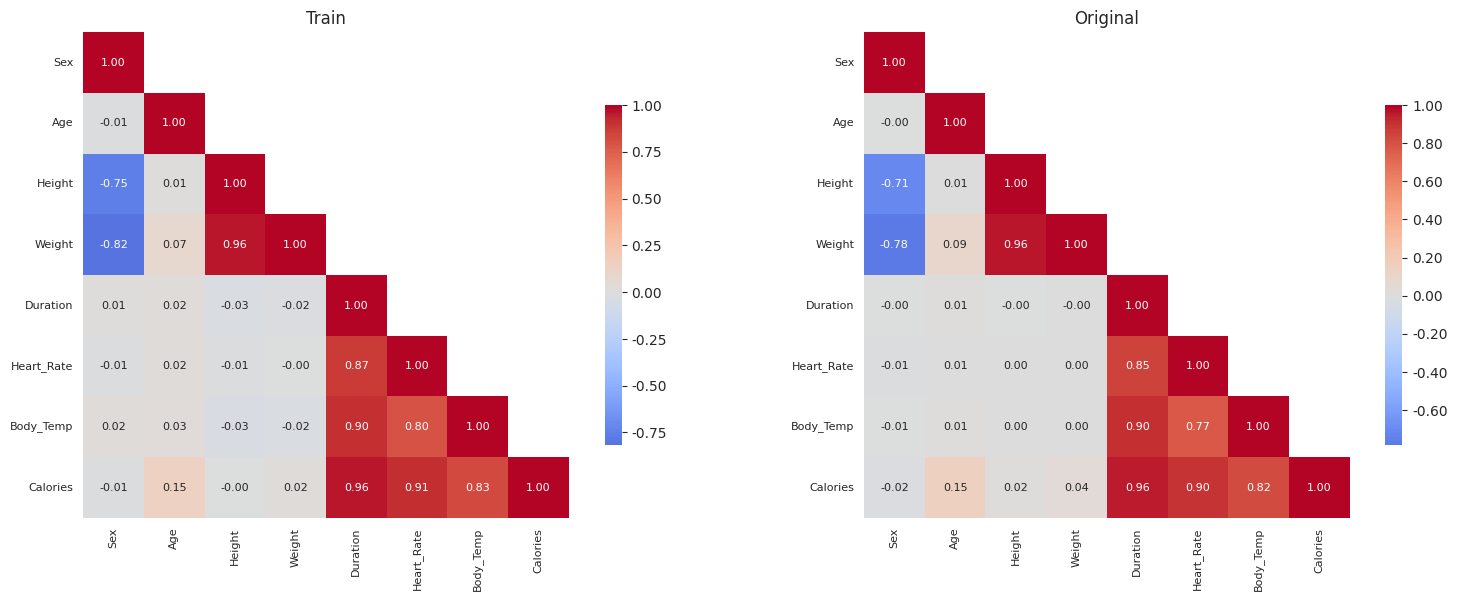

In [8]:
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

corr_train = train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=axes[0]
)
axes[0].set_title('Train')
axes[0].tick_params(axis='both', which='major', labelsize=8)

corr_orig = original.corr()
mask_orig = np.triu(np.ones_like(corr_orig, dtype=bool), k=1)
sns.heatmap(
    data=corr_orig,
    annot=True,
    fmt='.2f',
    mask=mask_orig,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=axes[1]
)
axes[1].set_title('Original')
axes[1].tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

# Training base models

In [9]:
histgb_params = {
    "l2_regularization": 10.412017522533768,
    "learning_rate": 0.011702680619474444,
    "max_depth": 59,
    "max_features": 0.30616140080552673,
    "max_iter": 4454,
    "max_leaf_nodes": 385,
    "min_samples_leaf": 50,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.8213924491907012,
    "learning_rate": 0.059976685297931195,
    "min_child_samples": 10,
    "min_child_weight": 0.5425237767880097,
    "n_estimators": 50000,
    "n_jobs": -1,
    "num_leaves": 89,
    "random_state": 42,
    "reg_alpha": 2.0325709613371545,
    "reg_lambda": 87.27971117911044,
    "subsample": 0.6452823633939004,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.9068724002629094,
    "learning_rate": 0.06459027654473874,
    "min_child_samples": 39,
    "min_child_weight": 0.5337673729810578,
    "n_estimators": 50000,
    "n_jobs": -1,
    "num_leaves": 13,
    "random_state": 42,
    "reg_alpha": 1.603969498256519,
    "reg_lambda": 10.806488455621444,
    "subsample": 0.5966412222358356,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.8606487417581108,
    "colsample_bynode": 0.9410596660335436,
    "colsample_bytree": 0.9407540036296737,
    "early_stopping_rounds": 100,
    "eval_metric": "rmse",
    "gamma": 0.023260595738991977,
    "learning_rate": 0.03669372905801298,
    "max_depth": 11,
    "max_leaves": 51,
    "min_child_weight": 96,
    "n_estimators": 50000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 2.953205886504917,
    "reg_lambda": 67.64147033446291,
    "subsample": 0.6973241930754311,
    "verbosity": 0
}

cb_params = {
    "border_count": 88,
    "colsample_bylevel": 0.7903437608890396,
    "depth": 8,
    "eval_metric": "RMSE",
    "iterations": 50000,
    "l2_leaf_reg": 6.065104074215131,
    "learning_rate": 0.030946464122148992,
    "min_child_samples": 138,
    "random_state": 42,
    "random_strength": 0.035251008593976785,
    "verbose": False
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8
}

In [10]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [11]:
histgb_trainer = Trainer(
    HistGradientBoostingRegressor(**histgb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="regression"
)

histgb_trainer.fit(X, y, extra_X=X_original, extra_y=y_original)

scores["HistGB"] = histgb_trainer.fold_scores
oof_preds["HistGB"] = histgb_trainer.oof_preds
test_preds["HistGB"] = histgb_trainer.predict(X_test)

Training HistGradientBoostingRegressor

--- Fold 0 - root_mean_squared_error: 0.0597 - Time: 89.32 s
--- Fold 1 - root_mean_squared_error: 0.0607 - Time: 81.66 s
--- Fold 2 - root_mean_squared_error: 0.0600 - Time: 88.61 s
--- Fold 3 - root_mean_squared_error: 0.0588 - Time: 81.68 s
--- Fold 4 - root_mean_squared_error: 0.0606 - Time: 77.26 s

------ Overall root_mean_squared_error: 0.0600 - Mean root_mean_squared_error: 0.0600 ± 0.0007 - Time: 420.31 s


## LightGBM (gbdt)

In [12]:
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_trainer.fit(X, y, fit_args=fit_args, extra_X=X_original, extra_y=y_original)

scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0598905	valid_0's l2: 0.00358687
Early stopping, best iteration is:
[1358]	valid_0's rmse: 0.0598093	valid_0's l2: 0.00357715
--- Fold 0 - root_mean_squared_error: 0.0598 - Time: 41.00 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.060384	valid_0's l2: 0.00364623
Early stopping, best iteration is:
[1323]	valid_0's rmse: 0.060328	valid_0's l2: 0.00363947
--- Fold 1 - root_mean_squared_error: 0.0603 - Time: 39.73 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0599937	valid_0's l2: 0.00359925
Early stopping, best iteration is:
[1356]	valid_0's rmse: 0.0599704	valid_0's l2: 0.00359645
--- Fold 2 - root_mean_squared_error: 0.0600 - Time: 40.30 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.05922	valid_0's l2: 0.003507
Early stopping, best iteration is:
[1

## LightGBM (goss)

In [13]:
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**lgbm_goss_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_goss_trainer.fit(X, y, fit_args=fit_args, extra_X=X_original, extra_y=y_original)

scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0601451	valid_0's l2: 0.00361743
[2000]	valid_0's rmse: 0.0597935	valid_0's l2: 0.00357526
[3000]	valid_0's rmse: 0.0596718	valid_0's l2: 0.00356073
Early stopping, best iteration is:
[3696]	valid_0's rmse: 0.0596379	valid_0's l2: 0.00355668
--- Fold 0 - root_mean_squared_error: 0.0596 - Time: 105.85 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0608205	valid_0's l2: 0.00369914
[2000]	valid_0's rmse: 0.0604416	valid_0's l2: 0.00365319
[3000]	valid_0's rmse: 0.0603428	valid_0's l2: 0.00364125
[4000]	valid_0's rmse: 0.0603032	valid_0's l2: 0.00363648
Early stopping, best iteration is:
[4184]	valid_0's rmse: 0.0602916	valid_0's l2: 0.00363508
--- Fold 1 - root_mean_squared_error: 0.0603 - Time: 116.99 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0605033	valid_0's l2: 0.00366064
[2000]	valid_0

## XGBoost

In [14]:
xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 1000
}

xgb_trainer.fit(X, y, fit_args=fit_args, extra_X=X_original, extra_y=y_original)

scores["XGBoost"] = xgb_trainer.fold_scores
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

[0]	validation_0-rmse:0.93123
[1000]	validation_0-rmse:0.06078
[2000]	validation_0-rmse:0.06071
[3000]	validation_0-rmse:0.06066
[3938]	validation_0-rmse:0.06064
--- Fold 0 - root_mean_squared_error: 0.0606 - Time: 100.15 s

[0]	validation_0-rmse:0.93046
[1000]	validation_0-rmse:0.06171
[2000]	validation_0-rmse:0.06160
[2804]	validation_0-rmse:0.06155
--- Fold 1 - root_mean_squared_error: 0.0616 - Time: 73.41 s

[0]	validation_0-rmse:0.92772
[1000]	validation_0-rmse:0.06072
[2000]	validation_0-rmse:0.06065
[2925]	validation_0-rmse:0.06063
--- Fold 2 - root_mean_squared_error: 0.0606 - Time: 77.06 s

[0]	validation_0-rmse:0.92907
[1000]	validation_0-rmse:0.05960
[2000]	validation_0-rmse:0.05955
[3000]	validation_0-rmse:0.05953
[3010]	validation_0-rmse:0.05953
--- Fold 3 - root_mean_squared_error: 0.0595 - Time: 81.05 s

[0]	validation_0-rmse:0.92904
[1000]	validation_0-rmse:0.06135
[2000]	validation_0-rmse:0.06129
[2360]	validation_0-rmse:0.06128
--- Fold 4 - root

## CatBoost

In [15]:
cb_trainer = Trainer(
    CatBoostRegressor(**cb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 1000,
    "early_stopping_rounds": 100,
    "use_best_model": True
}

cb_trainer.fit(X, y, fit_args=fit_args, extra_X=X_original, extra_y=y_original)

scores["CatBoost"] = cb_trainer.fold_scores
oof_preds["CatBoost"] = cb_trainer.oof_preds
test_preds["CatBoost"] = cb_trainer.predict(X_test)

Training CatBoostRegressor

0:	learn: 0.9345508	test: 0.9368764	best: 0.9368764 (0)	total: 125ms	remaining: 1h 44m 7s
1000:	learn: 0.0573208	test: 0.0591581	best: 0.0591581 (1000)	total: 54.2s	remaining: 44m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05902910702
bestIteration = 1873

Shrink model to first 1874 iterations.
--- Fold 0 - root_mean_squared_error: 0.0590 - Time: 106.68 s

0:	learn: 0.9347434	test: 0.9360404	best: 0.9360404 (0)	total: 67.6ms	remaining: 56m 21s
1000:	learn: 0.0572382	test: 0.0601504	best: 0.0601504 (1000)	total: 53.9s	remaining: 43m 59s
2000:	learn: 0.0561386	test: 0.0599487	best: 0.0599480 (1995)	total: 1m 47s	remaining: 42m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05990199703
bestIteration = 2882

Shrink model to first 2883 iterations.
--- Fold 1 - root_mean_squared_error: 0.0599 - Time: 161.59 s

0:	learn: 0.9354125	test: 0.9332895	best: 0.9332895 (0)	total: 67.6ms	remaining: 56m 21s
1000:	learn

## AutoGluon

In [16]:
oof_preds_files = glob.glob(f'/kaggle/input/s05e05-calorie-expenditure-prediction-automl/*_oof_preds_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s05e05-calorie-expenditure-prediction-automl/*_test_preds_*.pkl')

ag_oof_preds = np.log1p(joblib.load(oof_preds_files[0]))
ag_test_preds = np.log1p(joblib.load(test_preds_files[0]))

ag_scores = []
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]   
    score = root_mean_squared_error(y_preds, y_val)
    ag_scores.append(score)
    
oof_preds["AutoGluon"], test_preds["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

## Yggdrasil

In [17]:
def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [18]:
ydf_trainer = Trainer(
    YDFRegressor(GradientBoostedTreesLearner)(ydf_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="regression"
)

ydf_trainer.fit(X, y, extra_X=X_original, extra_y=y_original)

scores["Yggdrasil"] = ydf_trainer.fold_scores
oof_preds["Yggdrasil"] = ydf_trainer.oof_preds
test_preds["Yggdrasil"] = ydf_trainer.predict(X_test)

Training YDFXRegressor

--- Fold 0 - root_mean_squared_error: 0.0607 - Time: 87.03 s
--- Fold 1 - root_mean_squared_error: 0.0613 - Time: 76.55 s
--- Fold 2 - root_mean_squared_error: 0.0606 - Time: 109.08 s
--- Fold 3 - root_mean_squared_error: 0.0594 - Time: 100.65 s
--- Fold 4 - root_mean_squared_error: 0.0614 - Time: 88.16 s

------ Overall root_mean_squared_error: 0.0607 - Mean root_mean_squared_error: 0.0607 ± 0.0007 - Time: 463.28 s


## Neural networks

In [19]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train = train.drop_duplicates(subset=train.columns, keep='first').reset_index(drop=True)
train = train.groupby(by=test.columns.tolist())['Calories'].min().reset_index()

original = pd.read_csv(CFG.original_path, index_col="User_ID")
original = original.rename(columns={"Gender": "Sex"})

original = original.drop_duplicates(subset=original.columns, keep='first').reset_index(drop=True)
original = original.groupby(by=test.columns.tolist())['Calories'].min().reset_index()

X = train.drop(CFG.target, axis=1)
y = np.log1p(train[CFG.target])
X_test = test

X_original = original.drop(CFG.target, axis=1)
y_original = np.log1p(original[CFG.target])

In [20]:
pipeline = make_pipeline(
    ColumnTransformer(
        [
            ('one-hot-encode', OneHotEncoder(drop='first', sparse_output=False, dtype=np.float32, handle_unknown='ignore'), ['Sex']),
            
        ],
        remainder=StandardScaler()
    )
).set_output(transform='pandas')

X = pipeline.fit_transform(X, y)
X_test = pipeline.transform(X_test)
X_original = pipeline.transform(X_original)

In [21]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(1))
    return model

In [22]:
nn_model = KerasRegressor(
    get_model,
    loss="mean_squared_error",
    random_state=CFG.seed,
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer=keras.optimizers.AdamW(learning_rate=0.001),
    validation_batch_size=65536,
    validation_split=0.1,
    batch_size=1024,
    epochs=100, 
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_rmse', patience=7, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_rmse', patience=3, factor=0.3)
    ]
)

2025-05-12 20:04:33.511307: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [23]:
nn_bag = BaggingRegressor(
    nn_model,
    n_estimators=3,
    random_state=CFG.seed,
)

In [24]:
nn_trainer = Trainer(
    nn_bag,
    cv=CFG.cv,
    metric=root_mean_squared_error,
    task="regression"
)

nn_trainer.fit(X, y, extra_X=X_original, extra_y=y_original)

scores["KerasANN"] = nn_trainer.fold_scores
oof_preds["KerasANN"] = nn_trainer.oof_preds
test_preds["KerasANN"] = nn_trainer.predict(X_test)

Training BaggingRegressor



2025-05-12 20:04:34.105368: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-12 20:07:49.261746: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 0 - root_mean_squared_error: 0.0609 - Time: 450.94 s


2025-05-12 20:12:09.798611: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-12 20:14:16.012329: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 1 - root_mean_squared_error: 0.0617 - Time: 445.41 s


2025-05-12 20:19:35.926808: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-12 20:22:13.528240: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 2 - root_mean_squared_error: 0.0614 - Time: 429.39 s


2025-05-12 20:26:45.783426: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-12 20:28:56.685513: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 3 - root_mean_squared_error: 0.0600 - Time: 347.42 s


2025-05-12 20:32:33.974563: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-12 20:33:28.698426: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 4 - root_mean_squared_error: 0.0632 - Time: 284.27 s

------ Overall root_mean_squared_error: 0.0615 - Mean root_mean_squared_error: 0.0614 ± 0.0010 - Time: 1960.13 s


2025-05-12 20:37:16.194784: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-12 20:37:21.900763: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

# Ensembling with Ridge

In [25]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [26]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [27]:
joblib.dump(X, "oof_preds.pkl")
joblib.dump(X_test, "test_preds.pkl")

['test_preds.pkl']

In [28]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 10),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    trainer = Trainer(
        Ridge(**params),
        cv=CFG.cv,
        metric=CFG.metric,
        task="regression",
        verbose=False
    )
    trainer.fit(X, y)
    
    return trainer.overall_score

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-05-12 20:37:31,665] A new study created in memory with name: no-name-960f4b78-3a47-4a4b-9ca3-7ca1147f50e2
[I 2025-05-12 20:37:42,629] Trial 0 finished with value: 0.05924266885486895 and parameters: {'alpha': 8.311990217875223, 'tol': 0.009577897778945242}. Best is trial 0 with value: 0.05924266885486895.
[I 2025-05-12 20:37:44,557] Trial 1 finished with value: 0.059237539526281476 and parameters: {'alpha': 3.8453937493525894, 'tol': 0.00676948694569464}. Best is trial 1 with value: 0.059237539526281476.
[I 2025-05-12 20:37:44,564] Trial 3 finished with value: 0.05924445178435998 and parameters: {'alpha': 9.704859042573535, 'tol': 0.0024176454743933718}. Best is trial 1 with value: 0.059237539526281476.
[I 2025-05-12 20:37:44,567] Trial 2 finished with value: 0.05924362627858251 and parameters: {'alpha': 9.06354545323625, 'tol': 0.00904889769341354}. Best is trial 1 with value: 0.059237539526281476.
[I 2025-05-12 20:37:57,192] Trial 7 finished with value: 0.05924070710901866 an

In [29]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 0.7035117219847472,
  "tol": 0.006423788090132493
}


In [30]:
ridge_trainer = Trainer(
    Ridge(**ridge_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="regression"
)

ridge_trainer.fit(X, y)

scores["Ridge (ensemble)"] = ridge_trainer.fold_scores
ridge_test_preds = np.expm1(ridge_trainer.predict(X_test))

Training Ridge

--- Fold 0 - root_mean_squared_error: 0.0588 - Time: 0.13 s
--- Fold 1 - root_mean_squared_error: 0.0596 - Time: 0.13 s
--- Fold 2 - root_mean_squared_error: 0.0594 - Time: 0.13 s
--- Fold 3 - root_mean_squared_error: 0.0583 - Time: 0.13 s
--- Fold 4 - root_mean_squared_error: 0.0600 - Time: 0.14 s

------ Overall root_mean_squared_error: 0.0592 - Mean root_mean_squared_error: 0.0592 ± 0.0006 - Time: 3.82 s


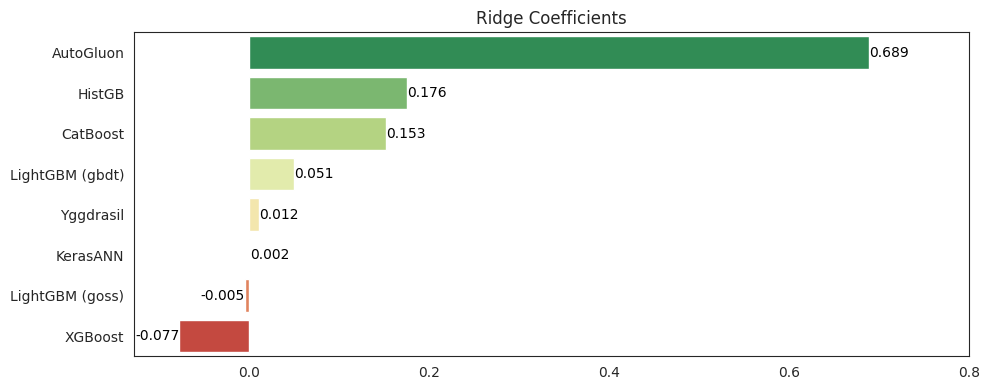

In [31]:
ridge_coeffs = np.zeros((1, X.shape[1]))
for m in ridge_trainer.estimators:
    ridge_coeffs += m.coef_
ridge_coeffs = ridge_coeffs / len(ridge_trainer.estimators)

plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [32]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Calories
0,750000,27.240289
1,750001,107.717765
2,750002,87.119592
3,750003,125.683626
4,750004,75.956334


# Results

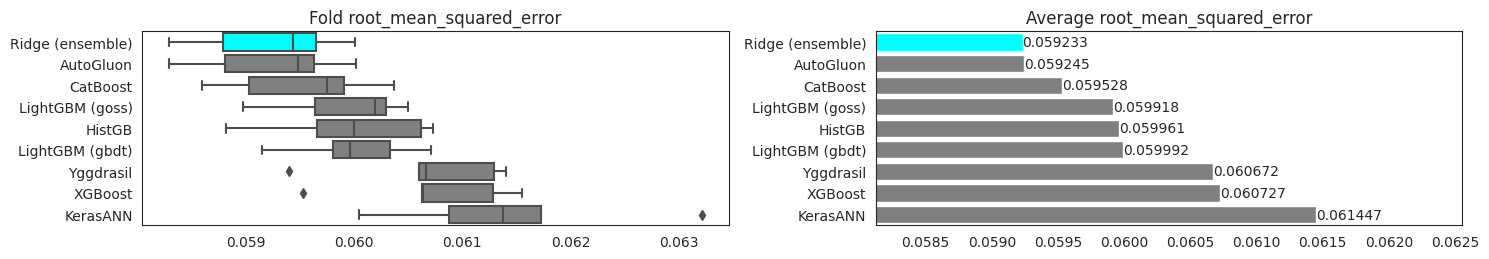

In [33]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric.__name__}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric.__name__}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [34]:
shutil.rmtree("catboost_info", ignore_errors=True)